In [1]:
#setup

import io
import os
import re
import shutil
import string
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from official.nlp import optimization 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print('gpu', gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    print('memory growth:' , tf.config.experimental.get_memory_growth(gpu))

from datetime import datetime
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
memory growth: True


In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

In [3]:
dataset_dir = os.path.join(os.path.dirname(dataset),"aclImdb")

In [4]:
train_dir = os.path.join(dataset_dir, "train")

In [5]:
test_dir = os.path.join(dataset_dir, "test")

In [6]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32 
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
#let's look at the data
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]} \n')
        label = label_batch.numpy()[i]
        print(f'Review: {class_names[label]} \n')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)' 

Review: neg 

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading model from tensorflow hub

In [9]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### Preprocessing the model

In [10]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

#### Let's try preprocessing the text

In [11]:
text_test = ['this is such an amazin movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  2107  2019 25933 17168  3185   999   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model

In [12]:
bert_model = hub.KerasLayer("https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [13]:
bert_results = bert_model(text_preprocessed)

In [14]:
print(f'Loaded BERT: {"https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://hub.tensorflow.google.cn/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9259365   0.98800856 -0.19743511  0.37368813  0.15152314  0.8873435
  0.9889833  -0.92985564 -0.2101778  -0.9876976   0.14422311 -0.9924086 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28861377  0.36370245  0.1447108  ... -0.02934333  0.64498407
   0.04631534]
 [-0.2597381   0.55556816 -0.38448718 ...  0.7138782  -0.3923432
   0.5076264 ]
 [-0.62348765  0.8062976  -0.80313444 ... -0.17430413 -0.31284583
   0.29353338]
 ...
 [ 0.10934766 -0.01838996  0.34280822 ... -0.3794307   0.84572613
   0.2269778 ]
 [-0.03763318 -0.09660204  0.15712254 ...  0.14222403  1.0095577
   0.22918141]
 [-0.07940094  0.00194373  0.09991713 ...  0.22456107  1.079193
   0.11690092]]


#### Define your model

In [15]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [16]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.38240725]], shape=(1, 1), dtype=float32)


## Model training

In [17]:
#loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [18]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [19]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [20]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 57s 85ms/step - loss: 0.5817 - binary_accuracy: 0.6538 - val_loss: 0.3921 - val_binary_accuracy: 0.8350
Epoch 2/5
625/625 [==============================] - 54s 87ms/step - loss: 0.3621 - binary_accuracy: 0.8351 - val_loss: 0.3813 - val_binary_accuracy: 0.8442
Epoch 3/5
625/625 [==============================] - 53s 86ms/step - loss: 0.2838 - binary_accuracy: 0.8813 - val_loss: 0.4036 - val_binary_accuracy: 0.8444
Epoch 4/5
625/625 [==============================] - 54s 86ms/step - loss: 0.2116 - binary_accuracy: 0.9149 - val_loss: 0.4370 - val_binary_accuracy: 0.8454
Epoch 5/5
625/625 [==============================] - 54s 86ms/step - loss: 0.1682 - binary_accuracy: 0.9348 - val_loss: 0.4903 - val_binary_accuracy: 0.8472


## Evaluate the model

In [21]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 31s 39ms/step - loss: 0.4640 - binary_accuracy: 0.8522
Loss: 0.4640098512172699
Accuracy: 0.8521999716758728


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


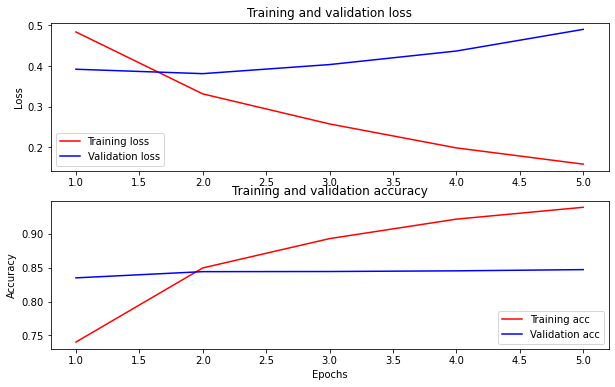

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [24]:
#save the model
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./imdb_bert/assets


INFO:tensorflow:Assets written to: ./imdb_bert/assets


In [25]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [30]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'This movie was tottaly awesome and I love it'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: This movie was tottaly awesome and I love it : score: 0.998740

Results from the model in memory:
input: This movie was tottaly awesome and I love it : score: 0.998740

